In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import xgboost
from sklearn.model_selection import GroupKFold, KFold
import uuid
import seaborn as sns

In [2]:
train  = pd.read_pickle('Feat5_119_oct_1_feats_train_More_items_past.pkl')
test = pd.read_pickle('Feat5_119_oct_1_feats_test_More_items_past.pkl')

In [3]:
#train.drop(['age_range','marital_status','rented','family_size','no_of_children','income_bracket'], axis = 1, inplace=True)
#test.drop(['age_range','marital_status','rented','family_size','no_of_children','income_bracket'], axis = 1, inplace=True)

In [4]:
# train['duration'] = train['duration'].dt.days
# test['duration'] = test['duration'].dt.days

In [5]:
campaignData = pd.read_csv('campaign_data.csv')
campaignData['start_date'] = pd.to_datetime(campaignData['start_date'], format= '%d/%m/%y')
campaignData['end_date'] = pd.to_datetime(campaignData['end_date'], format= '%d/%m/%y')
campaignData = campaignData.sort_values(by = 'start_date')
testCamp = test.campaign_id.unique()
trainCamp = train.campaign_id.unique()
campaignData['TrainOrTest'] = campaignData['campaign_id'].apply(lambda x : 'Train' if x in trainCamp else 'Test')

In [6]:
train.info(max_cols= 200)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78369 entries, 0 to 78368
Data columns (total 132 columns):
id                               78369 non-null int64
campaign_id                      78369 non-null int64
coupon_id                        78369 non-null int64
customer_id                      78369 non-null int64
redemption_status                78369 non-null int64
item_id_nunique                  78369 non-null int64
item_id_mode                     78369 non-null int64
quantity_mean                    78369 non-null float64
quantity_nunique                 78369 non-null int64
quantity_mode                    78369 non-null int64
quantity_std                     78369 non-null float64
quantity_max_                    78369 non-null int64
selling_price_mean               78369 non-null float64
selling_price_max_               78369 non-null float64
selling_price_min_               78369 non-null float64
selling_price_std                78369 non-null float64
other_discount

In [7]:
target = 'redemption_status'
cat = ['campaign_type', 'brand_type_mode', 'brand_type_category_mode', 'brand_category_mode', 
      'CoupBrandTypeMode', 'age_range', 'marital_status']

In [8]:
moreCat = [x for x in train.columns if ('mode' in x.lower())]

In [9]:
cat = list(set(cat + moreCat))

In [10]:
# All = train.append(test)

In [11]:
# def one_hot_encoder(df, nan_as_category = False):
#     original_columns = list(df.columns)
#     categorical_columns = cat
#     df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
#     new_columns = [c for c in df.columns if c not in original_columns]
#     return df, new_columns
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))

In [12]:
#All, newCols = one_hot_encoder(All, nan_as_category=True)

In [13]:
# train = All[~All.redemption_status.isnull()]
# test = All[All.redemption_status.isnull()]

In [14]:
toDrop = [x for x in train.columns if train[x].nunique() == 1]

In [15]:
#moreToDrop = [x for x in train.columns if x.startswith('Coup')]
moreToDrop = []

In [16]:
notTrainOn = ['id', 'campaign_id']
trainOn = [x for x in train.columns if (x not in notTrainOn ) & (x not in toDrop) & (x!=target) & (x not in moreToDrop)]

In [17]:
catIndex = [i for i,_ in enumerate(trainOn) if _ in cat]

In [18]:
gkf = KFold(n_splits=5)

In [19]:
catIndex = [i for i,x in enumerate(trainOn) if x in cat]

In [20]:
#trainOn.remove('itemPastIsCouponDiscMean')

In [21]:
oof = np.zeros_like(train[target])
oot = np.zeros_like(test['id']).astype('float')
feature_importance_df = pd.DataFrame()

In [22]:
oof = oof.astype('float')

In [23]:
import catboost as cbg

In [24]:
def getResultSummary(res):
    trainMean = np.mean(list(map(lambda x : x[0], res)))
    validMean = np.mean(list(map(lambda x : x[1], res)))
    trainStd = np.std(list(map(lambda x : x[0], res)))
    validStd = np.std(list(map(lambda x : x[1], res)))
    return {
        
        'Train Mean' : trainMean, 
        'Valid Mean' : validMean, 
        'Train Std'  : trainStd,
        'Valid Std'  : validStd
    }

In [25]:
import catboost as cbg

In [26]:
import lightgbm as lgb

In [27]:
for x in cat:
    train[cat] = train[cat].astype('str')
    test[cat] = test[cat].astype('str')

In [28]:
results = []
featureImp = []
i = 0
for train_index, test_index in gkf.split(train[trainOn], train[target]):
    train_X = train.iloc[train_index][trainOn]
    valid_X = train.iloc[test_index][trainOn]
    train_y = train.iloc[train_index][target]
    valid_y = train.iloc[test_index][target]
    model = cbg.CatBoostClassifier(iterations=2500, eval_metric='AUC', random_state=1234567884, od_wait=400, colsample_bylevel=0.6, learning_rate=0.03)
    model.fit(train_X, train_y,  eval_set= [(train_X, train_y), 
                                        (valid_X, valid_y)],
                            verbose = 100, cat_features = catIndex)
    valid_pred = model.predict_proba(valid_X)[:,1]
    train_pred = model.predict_proba(train_X)[:,1]
    trainRes = roc_auc_score(train_y, train_pred)
    validRes = roc_auc_score(valid_y, valid_pred)
    oof[test_index] = valid_pred
    print(oof[test_index])
    ootPred = model.predict_proba(test[trainOn])[:,1]
    oot += ootPred / 5
    results.append((trainRes, validRes))
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = trainOn
    fold_importance_df["importance"] = model.feature_importances_
    fold_importance_df["fold"] = i + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    i+=1

0:	test: 0.7424607	test1: 0.7636848	best: 0.7636848 (0)	total: 167ms	remaining: 6m 57s
100:	test: 0.9441805	test1: 0.9437853	best: 0.9438059 (98)	total: 7.29s	remaining: 2m 53s
200:	test: 0.9540561	test1: 0.9507181	best: 0.9507181 (200)	total: 15.5s	remaining: 2m 57s
300:	test: 0.9591693	test1: 0.9530729	best: 0.9530729 (300)	total: 23.1s	remaining: 2m 48s
400:	test: 0.9633120	test1: 0.9545257	best: 0.9548486 (378)	total: 31.7s	remaining: 2m 45s
500:	test: 0.9673566	test1: 0.9560564	best: 0.9560564 (500)	total: 40.5s	remaining: 2m 41s
600:	test: 0.9703428	test1: 0.9576474	best: 0.9577113 (597)	total: 54.6s	remaining: 2m 52s
700:	test: 0.9731984	test1: 0.9593922	best: 0.9593922 (700)	total: 1m 8s	remaining: 2m 56s
800:	test: 0.9756734	test1: 0.9599860	best: 0.9599972 (796)	total: 1m 22s	remaining: 2m 55s
900:	test: 0.9778989	test1: 0.9600531	best: 0.9601663 (815)	total: 1m 34s	remaining: 2m 48s
1000:	test: 0.9800426	test1: 0.9604243	best: 0.9604243 (1000)	total: 1m 46s	remaining: 2m 39s

1700:	test: 0.9914931	test1: 0.9598711	best: 0.9601350 (1558)	total: 2m 43s	remaining: 1m 16s
1800:	test: 0.9925069	test1: 0.9601323	best: 0.9602003 (1797)	total: 2m 52s	remaining: 1m 7s
1900:	test: 0.9933346	test1: 0.9602515	best: 0.9605734 (1862)	total: 3m 2s	remaining: 57.4s
2000:	test: 0.9942289	test1: 0.9599849	best: 0.9605734 (1862)	total: 3m 11s	remaining: 47.8s
2100:	test: 0.9950198	test1: 0.9605403	best: 0.9605734 (1862)	total: 3m 21s	remaining: 38.2s
2200:	test: 0.9957451	test1: 0.9601649	best: 0.9607009 (2127)	total: 3m 30s	remaining: 28.7s
2300:	test: 0.9962736	test1: 0.9599264	best: 0.9607009 (2127)	total: 3m 40s	remaining: 19.1s
2400:	test: 0.9968000	test1: 0.9602311	best: 0.9607009 (2127)	total: 3m 49s	remaining: 9.48s
2499:	test: 0.9972304	test1: 0.9601690	best: 0.9607009 (2127)	total: 3m 59s	remaining: 0us

bestTest = 0.960700852
bestIteration = 2127

Shrink model to first 2128 iterations.
[6.22098557e-04 3.50334136e-04 9.95854935e-05 ... 3.66546456e-04
 4.26159524e-04

In [29]:
valid_pred

array([0.02479298, 0.00053599, 0.00033385, ..., 0.00443543, 0.0014671 ,
       0.01420563])

In [30]:
getResultSummary(results)

{'Train Mean': 0.9892780065478082,
 'Valid Mean': 0.9523504271287363,
 'Train Std': 0.0068450048664522485,
 'Valid Std': 0.00926864128649743}

In [31]:
results

[(0.9872505081279835, 0.96381868426701),
 (0.9958804339746401, 0.9382809484754921),
 (0.9909131730785403, 0.9468479803845657),
 (0.9952452034698254, 0.9607008520346908),
 (0.9771007140880517, 0.9521036704819227)]

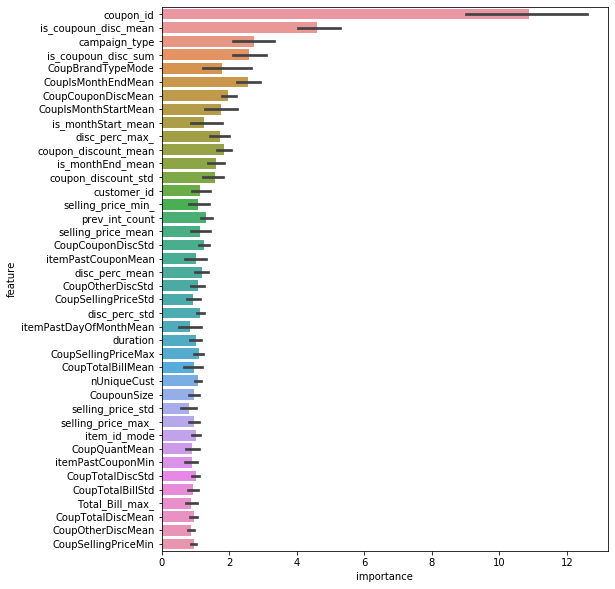

In [32]:
display_importances(feature_importance_df)

In [33]:
def saveStackingFile(prefix):
    oof_ = pd.DataFrame(oof,columns = [prefix])
    oot_ = pd.DataFrame(oot,columns = [prefix])
    print(oof_.shape, oot_.shape)
    oof_.to_csv(prefix + '_train.csv', index = False)
    oot_.to_csv(prefix + '_test.csv', index = False)

In [34]:
saveStackingFile('CGB_Feat5_All_Possible_Feats_5_Fold')

(78369, 1) (50226, 1)


In [ ]:
test[target] = oot

In [ ]:
fileName = str(uuid.uuid4()).split('-')[-1]

In [121]:
test[['id', target]].to_csv(fileName + '.csv', index = False)